In [1]:
#Pennylane tutorial:https://pennylane.ai/qml/demos/tutorial_vqe.html

In [2]:
#!pip install pennylane-qchem
#!pip install PennyLane

In [37]:
import matplotlib.pyplot as plt

In [7]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

In [8]:
DATA_PATH='/content/drive/MyDrive/Projects/CQ/Data/'

In [18]:
geometry = 'h2.xyz'
charge = 0
multiplicity = 1
basis_set = 'sto-3g'
name = 'h2'
nr_e=2

In [19]:
h, qubits = qchem.molecular_hamiltonian(
    name,
    DATA_PATH+geometry,
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    active_electrons=nr_e,
    active_orbitals=2,
    mapping='jordan_wigner'
)

print('Number of qubits = ', qubits)
print('Hamiltonian is ', h)

Number of qubits =  4
Hamiltonian is  (-0.05365019756279028) [I0]
+ (0.1764299696762176) [Z0]
+ (0.1764299696762176) [Z1]
+ (-0.23874672913690942) [Z2]
+ (-0.23874672913690942) [Z3]
+ (0.1702161957058614) [Z0 Z1]
+ (0.04485941594748865) [Y0 X1 X2 Y3]
+ (-0.04485941594748865) [Y0 Y1 X2 X3]
+ (-0.04485941594748865) [X0 X1 Y2 Y3]
+ (0.04485941594748865) [X0 Y1 Y2 X3]
+ (0.12247041940076897) [Z0 Z2]
+ (0.16732983534825763) [Z0 Z3]
+ (0.16732983534825763) [Z1 Z2]
+ (0.12247041940076897) [Z1 Z3]
+ (0.1759005512371066) [Z2 Z3]


In [21]:
initial_state=[ 0 for i in range(qubits)]
for i in range(nr_p):
  initial_state[i]=1
nr_o=qubits
nr_par=(nr_o-nr_e)*nr_e
dev = qml.device('default.qubit', wires=qubits)

In [44]:
def circuit(params, wires):
  
    qml.BasisState(np.array(initial_state, requires_grad=False), wires=wires)
    

    it=0
    start=nr_p-1
    limit=nr_o
    while start!=-1:
        cq=start
        tq=start+1
        while tq<limit:

            qml.CNOT(wires=[cq,tq])
            qml.PauliZ(tq)
            qml.CRY(np.pi-2*params[it],wires=[tq,cq])
            qml.CNOT(wires=[cq,tq])

            it=it+1
            cq=cq+1
            tq=tq+1

        start=start-1
        limit=limit-1
    

In [45]:
cost_fn = qml.ExpvalCost(circuit, h, dev)

In [46]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)
np.random.seed(0)
params = np.random.normal(0, np.pi, (nr_par, 1))

print(params)

[[5.54193389]
 [1.25713095]
 [3.07479606]
 [7.03997361]]


In [47]:
costs=[]
max_iterations = 400
conv_tol = 1e-06


for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    energy = cost_fn(params)
    conv = np.abs(energy - prev_energy)
    costs.append(energy)

    if n % 20 == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha'.format(n, energy))

    if conv <= conv_tol:
        break

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print('Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)'.format(
    np.abs(energy - (-1.136189454088)), np.abs(energy - (-1.136189454088))*627.503
    )
)
print()
print('Final circuit parameters = \n', params)

Iteration = 0,  Energy = -0.70219626 Ha

Final convergence parameter = 0.00000051 Ha
Final value of the ground-state energy = -1.11748700 Ha
Accuracy with respect to the FCI energy: 0.01870246 Ha (11.73584819 kcal/mol)

Final circuit parameters = 
 [[4.71291824]
 [1.46813925]
 [2.70343472]
 [7.85325516]]


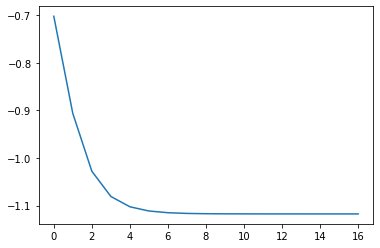

In [48]:
plt.figure()
plt.plot(costs)
plt.show()